<a href="https://colab.research.google.com/github/williameclee/trade-cumulus-inversion/blob/main/invtci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trade Cumulus Inversion

## Loading of necessary libraries

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from inv import *


## Speficication of experiment parameters

In [2]:
kc = 60
kcp = kc + 1
kcm = kc - 1
jc = 81
jt = 2 * jc - 1
jl = 60

# Constants
R = 287
cp = 1004
kappa = R / cp
gr = 9.81
Ae = 6.371e06
Omega = 7.292e-05
rom = Ae * Omega

thetat = 320  # theta (kelvin) at model top
thetab = 300  # theta (kelvin) at model bottom
sigma0 = 45  # sigma0 (hPa/K)

pb = 1000  # pressure (hPa) at model bottom
dp = 58  # pressure (hPa) change across inversion
theta10 = 303  # mean theta (kelvin) in inversion
dtheta = 4  # dtheta (kelvin) of inversion
thetac = 3  # thetac (kelvin) of inversion

phis = -180 / 8  # southern extent of inversion (degrees)
phin = 180 / 8  # northern extent of inversion (degrees)
phic = 0  # latitude (degrees) of inversion center

dp = dp * 100  # pressure (Pa) change across inversion
pb = pb * 100  # pressure (Pa) at model bottom
sigma0 = sigma0 * 100  # sigma0 (Pa/K)

pt = pb - sigma0 * (thetat - thetab) + dp
alpha = (pb - pt) / pb
beta = thetab / (thetat - thetab)
cs = alpha * R * (thetat - thetab)
eps = 4 * rom * rom / cs

## Create coordinates

In [3]:
## Horizontal grid
sc = np.linspace(-1, 1, 2 * jc + 1)  # originally sc, uniform grid from -1 to 1
dsc = sc[1] - sc[0]
phi = np.rad2deg(np.arcsin(sc))

scs = sc**2
fac1 = eps * dsc * sc
f1 = fac1 * (1 - scs)

## Vertical grid
z = np.linspace(0, 1, kc + 1)
dz = z[1] - z[0]
theta = np.linspace(thetab, thetat, kc + 1)
tdz = 2 * dz
fac2 = 2 * dsc * dz**2

## Initialise variables

/var/folders/bm/k1ffy7j930jdkxs326mj3pt80000gn/T/ipykernel_49369/456776885.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


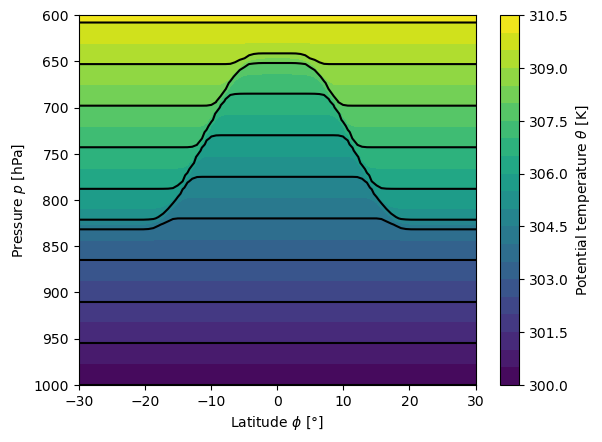

In [15]:
# initialise potential temperature theta
theta1 = np.zeros(2 * jc + 1)
theta2 = np.zeros(2 * jc + 1)

phi_N = (phi <= phin) & (phi > phic)
phi_S = (phi >= phis) & (phi < phic)
phi_C = phi == phic
theta1[:] = theta10
theta1[phi_N] = theta10 + dtheta * fexp((phin - phi[phi_N]) / (phin - phic))
theta1[phi_S] = theta10 + dtheta * fexp((phi[phi_S] - phis) / (phic - phis))
theta1[phi_C] = theta10 + dtheta
theta2 = theta1 + thetac

# initialise pressure, gamma and x (i.e., m) at even points
pres = np.zeros((2 * jc + 1, kc + 1))

theta2_grid, theta_grid = np.meshgrid(theta2, theta, indexing="ij")
theta1_grid, theta_grid = np.meshgrid(theta1, theta, indexing="ij")
theta_T = theta_grid >= theta2_grid
theta_C = (theta_grid < theta2_grid) & (theta_grid >= theta1_grid)
theta_B = theta_grid < theta1_grid

pres[theta_B] = pb - sigma0 * (theta_grid[theta_B] - thetab)
pres[theta_T] = pb - sigma0 * (theta_grid[theta_T] - thetab) + dp
pres[theta_C] = (
    pb
    - sigma0 * (theta_grid[theta_C] - thetab)
    + dp * fexp((theta_grid[theta_C] - theta1_grid[theta_C]) / thetac)
)

pres = pres / pb  # normalise pressure

gamma = pres ** (kappa - 1)

refp = np.mean(pres, axis=0)

# Visualise pressure
## interpolation
press = np.linspace(1, 0.6, kc + 1)
theta_grid = np.zeros((2 * jc + 1, kc + 1))
for j in range(2 * jc + 1):
    f_theta = sp.interpolate.interp1d(
        pres[j, :], theta, bounds_error=False, fill_value=0
    )
    theta_grid[j, :] = f_theta(press)

## plot
fig, ax = plt.subplots()
contourf_p = ax.contourf(
    phi, press * pb / 100, theta_grid.T, levels=np.arange(300, 311, 0.5)
)
contour_p = ax.contour(
    phi, press * pb / 100, theta_grid.T, levels=np.arange(300, 320, 1), colors="k"
)
ax.set_xlim(-30, 30)
ax.set_ylim(1000, 600)
ax.set_xlabel(r"Latitude $\phi$ [°]")
ax.set_ylabel(r"Pressure $p$ [hPa]")
fig.colorbar(contourf_p, label=r"Potential temperature $\theta$ [K]")
fig.show()

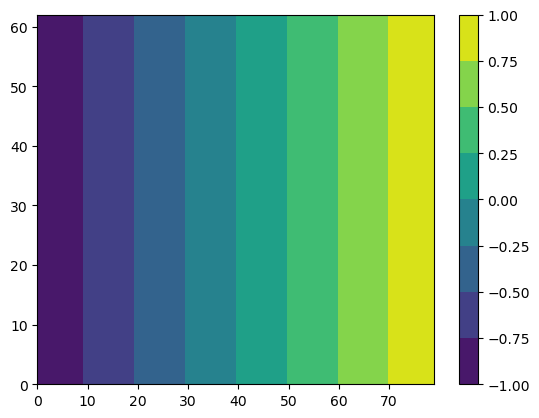

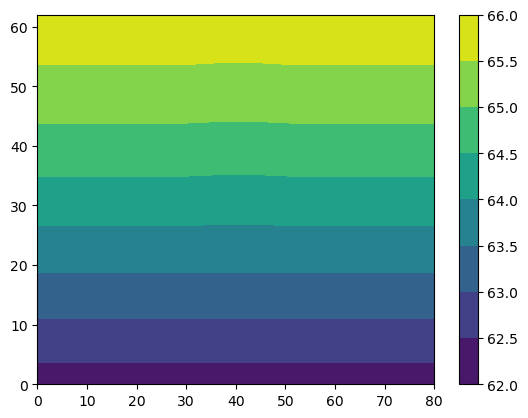

In [34]:
# compute initial m field at even points
x = np.zeros((2 * jc - 1, kcp + 2))  # (-jc+1:jc-1,-1:kcp)
xtmp = np.zeros(kc + 1)  # (0:kc)
ftmp = np.zeros(kc + 1)  # (0:kc)

method = 1
x[:,0] = cp * thetab / cs
for j in range(0, 2 * jc - 1, 2):
    ftmp = pres[j, :] ** kappa / (kappa * alpha)
    xtmp = intdde(method, kc, dz, x[j, 0], ftmp)
    x[j, 1:-1] = xtmp
    x[j, 0] = x[j, 1] - tdz * x[j, 0] / beta
    x[j, -1] = x[j, -3] + tdz * (1 - alpha) ** kappa / (kappa * alpha)

# initialise x (i.e., sin(phi)) at odd points
x[1:-1:2,:] = np.tile(sc[2:-2:2],(kcp+2,1)).T 

plt.contourf(x[1:-1:2, :].T)
plt.colorbar()
plt.show()
plt.contourf(x[::2, :].T)
plt.colorbar()
plt.show()

## Compute Sigma

/var/folders/bm/k1ffy7j930jdkxs326mj3pt80000gn/T/ipykernel_49369/737885663.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


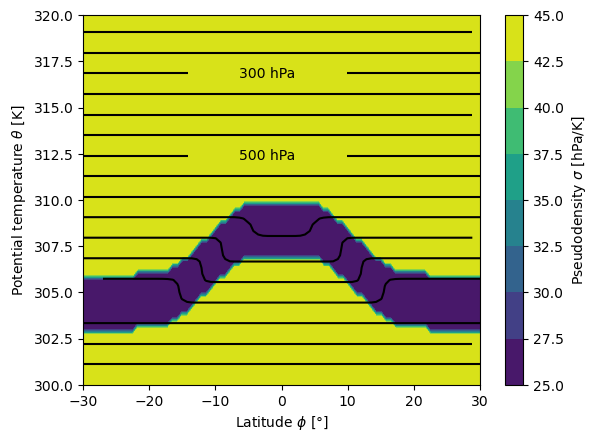

In [61]:
tinc = 0.1
sigma = np.zeros((2 * jc + 1, kc + 1))  # (-jc:jc,0:kc)
lat = np.zeros(2 * jl + 1)  # (-jl:jl)

# Calculate sigma values
sigma[theta_T | theta_B] = 1
for k in range(kc + 1):
    for j in range(2 * jc + 1):
        if theta[k] < theta2[j] and theta[k] >= theta1[j]:
            tp = theta[k] + tinc
            tm = theta[k] - tinc
            fp = (tp - theta1[j]) / (theta2[j] - theta1[j])
            fm = (tm - theta1[j]) / (theta2[j] - theta1[j])
            dfdt = (fp - fm) / (2 * tinc)
            sigma[j, k] = (sigma0 - dp * dfdt) / sigma0

phimin = -30  # phimin (degrees) for plot
phimax = 30  # phi max (degrees) for plot
ptop = 300 # ptop (hPa) for plot

# interpolate potential latitude and theta postions to actual latitude
lat = np.linspace(phimin, phimax, 2 * jl + 1)
dl = lat[1] - lat[0]

# ignoring line 255 of calling int

# Visualise sigma
fig, ax = plt.subplots()
contourf_sigma = ax.contourf(phi, theta, sigma.T * sigma0 / 100)
contour_pres = ax.contour(
    phi, theta, pres.T * pb / 100, colors="k", levels=np.arange(100, 1000, 50)
)
ax.clabel(contour_pres, levels=np.arange(100, 1000, 100), fmt="%d hPa")
ax.set_xlim(-30, 30)
ax.set_ylim(300, 320)
fig.colorbar(contourf_sigma, label=r"Pseudodensity $\sigma$ [hPa/K]")
ax.set_xlabel(r"Latitude $\phi$ [°]")
ax.set_ylabel(r"Potential temperature $\theta$ [K]")
fig.show()

plt.plot(lat)
plt.show()

## Iteration

In [8]:
nmax = 100  # maximum number of iterations
nup = 10  # print out the residual norm every nup iterations

u = np.zeros((2 * jc - 1, kc + 1))  # (-jc+1:jc-1,0:kc)
d = np.zeros((2 * jc - 1, kc + 1))  # (-jc+1:jc-1,0:kc)
g = np.zeros((2 * jc - 1, kc + 1))  # (-jc+1:jc-1,0:kc)
l = np.zeros((2 * jc - 1, kc + 1))  # (-jc+1:jc-1,0:kc)

niter = 1
n = 0
n = n + 1
if n > nmax:
    print("Maximum number of iterations exceeded")
    exit()
else:
    rn = 0
    # Zebra relaxation in horizontal direction
    # first relax even horizontal lines, then odd lines
    for ks in range(2):
        iter = 0
        while iter < niter:
            iter += 1
            for k in range(ks, kc + 1, 2):
                kp = k + 1
                km = k - 1
                # fill in matrix elements for even points
                # point adjacent to south pole
                # using sin(phi)=sin(Phi)=-1 for boundary condition at south pole
                j = 0
                jp = j + 1
                dxds = x[jp, k] + 1
                dxdz2 = x[j, kp] - 2 * x[j, k] + x[j, km]
                f2 = x[jp, k] - 1
                f3 = 1 - 0.25 * f2**2
                f4 = (0.25 * (x[jp, kp] - x[jp, km])) ** 2
                term2 = f1[j] * f4 * (1 + 0.75 * f2 * f2) / (f3 * f3 * f3)
                u[j, k] = dxdz2 + term2
                d[j, k] = -2 * dxds
                g[j, k] = -(
                    dxds * dxdz2
                    + f1[j] * f2 * f4 / (f3 * f3)
                    + gamma[j, k] * sigma[j, k] * fac2
                )
                for j in range(2, 2 * jc - 2, 2):
                    jm = j - 1
                    jp = j + 1
                    dxds = x[jp, k] - x[jm, k]
                    dxdz2 = x[j, kp] - 2.0 * x[j, k] + x[j, km]
                    f2 = x[jp, k] + x[jm, k]
                    f3 = 1.0 - 0.25 * f2 * f2
                    f4 = (0.25 * (x[jp, kp] + x[jm, kp] - x[jp, km] - x[jm, km])) ** 2
                    term2 = f1[j] * f4 * (1.0 + 0.75 * f2 * f2) / (f3 * f3 * f3)
                    u[j, k] = dxdz2 + term2
                    d[j, k] = -2.0 * dxds
                    l[j, k] = -dxdz2 + term2
                    g[j, k] = -(
                        dxds * dxdz2
                        + f1[j] * f2 * f4 / (f3 * f3)
                        + gamma[j, k] * sigma[j, k] * fac2
                    )
                # fill in matrix elements for odd points
                for j in range(1, 2 * jc - 1, 2):
                    jm = j - 1
                    jp = j + 1
                    xjs = x[j, k] * x[j, k]
                    fj = xjs - scs[j]
                    dj = 1.0 - xjs
                    l[j, k] = -1.0
                    d[j, k] = fac1[j] * (2.0 * x[j, k] * (1.0 - scs[j]) / (dj * dj))
                    u[j, k] = 1.0
                    g[j, k] = -(fac1[j] * (fj / dj) + x[jp, k] - x[jm, k])
            # do matrix factorisation
            mm = (kc + 2 - ks) / 2
            nn = jt
            inc = 1
            jump = 2 * jt
            js = -jc + 1
            l[js, ks], d[js, ks], u[js, ks] = gtdmsf(
                mm, nn, l[js, ks], d[js, ks], u[js, ks], inc, jump
            )
            l[js, ks], d[js, ks], u[js, ks], g[js, ks] = gtdmss(
                mm, nn, l[js, ks], d[js, ks], u[js, ks], g[js, ks], inc, jump
            )

TypeError: 'float' object cannot be interpreted as an integer